In [1]:
import numpy as np
from PIL import Image, ImageDraw
from acl_model import Model
import cv2
import matplotlib.pyplot as plt

In [2]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

In [3]:
device_id = 1
input_size = 416
model_path = "./model/yolov3_coco_tf_rgb888.om"

In [4]:
model = Model(device_id, model_path, input_size, input_size)

[ACL] init resource stage:
[ACL] init resource stage success
[Model] class Model init resource stage:
[Model] create model output dataset:
[Model] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input/input_data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
model output size 3
output  0
model output dims ({'name': 'pred_sbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 52, 52, 3, 85]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'pred_mbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 26, 26, 3, 85]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'pred_lbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 13, 13, 3, 85]}, 0)
model output datatype 0
[Model] class Model init resource stage success


In [24]:
img_dict = {"path": "./data/dog.jpg", "dtype": np.uint8}

In [25]:
img_org_bgr = cv2.imread(img_dict["path"])

In [26]:
# bgr -> yuv -> inference ~14.4 ms; npu usage about 95%
# bgr -> rgb -> inference ~18.2 ms; npu usage about 75% (it is moving twice as much data from host to device, hence the performance)

In [27]:
import acl
from constant import ACL_MEMCPY_DEVICE_TO_HOST, NPY_BYTE
import struct
from acl_util import check_ret

In [28]:
%timeit -n 100 -r 10 
model_output = model.run(img_org_bgr)

87249314
img_buf_size 519168
[Model] create model input dataset:
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success


In [29]:
def get_model_output_by_index(model_output, i):
    temp_output_buf = acl.mdl.get_dataset_buffer(model_output, i)

    infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
    infer_output_size = acl.get_data_buffer_size(temp_output_buf)
    print("infer_output_size", infer_output_size)
    
    output_host, _ = acl.rt.malloc_host(infer_output_size)
    acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                          infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)
    
    return acl.util.ptr_to_numpy(output_host, (infer_output_size//4,), 11).reshape(-1, 85)
    return np.array(struct.unpack(f"{infer_output_size//4}f", bytearray(result)), dtype=np.float32).reshape(-1, 85)

In [30]:
pred_sbbox = get_model_output_by_index(model_output, 0)
pred_mbbox = get_model_output_by_index(model_output, 1)
pred_lbbox = get_model_output_by_index(model_output, 2)

infer_output_size 2758080
infer_output_size 689520
infer_output_size 172380


In [31]:
import sys
sys.path.append("/home/a800/tianyu/tensorflow-yolov3")

In [32]:
import core.utils as utils

In [33]:
pred_bbox = np.concatenate([pred_sbbox,
                            pred_mbbox,
                            pred_lbbox], axis=0)

In [34]:
original_image_size = img_org_bgr.shape[:2]

In [35]:
%timeit -n 100 -r 10 
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)

In [36]:
bboxes = utils.nms(bboxes, 0.45, method='nms')

In [37]:
img = Image.open(img_dict["path"])

In [38]:
img1 = ImageDraw.Draw(img)
for bbox in bboxes:
    img1.rectangle(list(bbox[:4]), outline ="red", width=2)
    print(bbox[:4], bbox[4], bbox[5], coco_labels[int(bbox[5])])

[122.36537933 231.80767822 313.09613037 530.65380859] 0.9960966110229492 16.0 dog
[112.61537933 118.7307663  571.38458252 444.34613037] 0.9970722198486328 1.0 bicycle
[479.59613037  79.47115326 684.40380859 169.75961304] 0.8941440582275391 7.0 truck


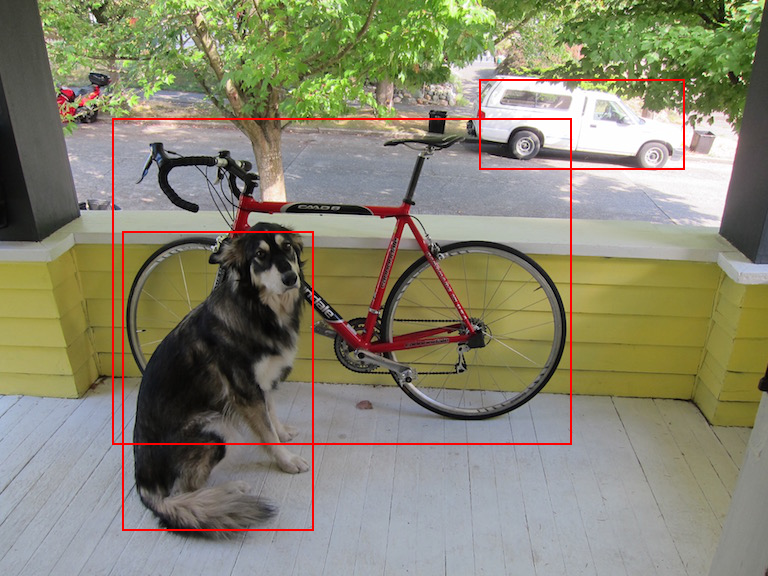

In [39]:
img